In [6]:
%reload_ext autoreload
%autoreload 2

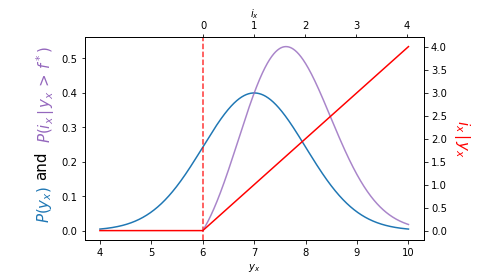

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

## Plot improvement

mu = 7
sig = 1

x = np.linspace(mu - 3*sig, mu + 3*sig, 1000)


fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(x, norm(mu, sig).pdf(x))

best_f = 6

ax.axvline(x=np.asarray(best_f), linestyle="--", color="red", alpha=0.8)
#axs[0].set_ylabel('$P(y_x)$', color = 'tab:blue')
ax.set_xlabel('$y_x$')

I = x - best_f
I[I < 0] = 0


ax2 = ax.twinx()

ax2.plot(x, I, color='red')
ax2.set_ylabel('$i_x\,|\,y_x$', color = 'red', size=15, rotation=-90, labelpad=25)

#ax.plot(I, I*norm(mu, sig).pdf(x), color = 'red', alpha = 0.8)
#ax.set_ylabel('P($i_x\,|\,i_x\,>\,0$)')
#ax.set_xlabel('$i_x$')

#ax3 = axs[0].twiny()
ax.plot(I+best_f, I*norm(mu, sig).pdf(x), color = 'tab:purple', alpha = 0.8)
#axs[0].set_ylabel('P($i_x\,|\,i_x > 0$)')
#axs[0].set_xlabel('$i_x$')
#ax3.xaxis.set_major_locator(LinearLocator(min=6, max=10))

ax3 = ax.twiny()
ax3.set_xlim([-2 - 1/3, 4 + 1/3])
ax3.set_xticks([0, 1, 2, 3, 4])
ax3.set_xticklabels(['0','1','2','3','4'])
ax3.set_xlabel('$i_x$')

ybox1 = TextArea("$P(i_x\,|\,y_x\,>\,f^*$) ", textprops=dict(color="tab:purple", size=15,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea("and",     textprops=dict(color="k", size=15,rotation=90,ha='left',va='bottom'))
ybox3 = TextArea("$P(y_x)\,$ ", textprops=dict(color="tab:blue", size=15,rotation=90,ha='left',va='bottom'))

ybox = VPacker(children=[ybox1, ybox2, ybox3], align="top", pad=0., sep=5)

anchored_ybox = AnchoredOffsetbox(loc='center left', child=ybox, pad=-5., frameon=False, #bbox_to_anchor=(-0.08, 0.4), 
                                  bbox_transform=ax.transAxes, borderpad=0.)

ax.add_artist(anchored_ybox)

plt.tight_layout()
plt.show()


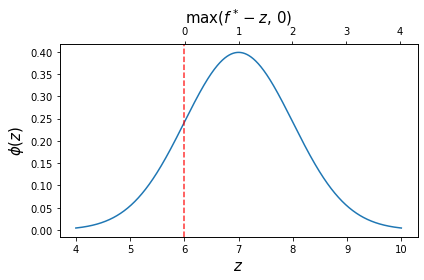

In [8]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

## Plot improvement

mu = 7
sig = 1

x = np.linspace(mu - 3*sig, mu + 3*sig, 1000)


fig, ax1 = plt.subplots(1, figsize=(6,4))
ax1.plot(x, norm(mu, sig).pdf(x))

best_f = 6

ax1.axvline(x=np.asarray(best_f), linestyle="--", color="red", alpha=0.8)
ax1.set_ylabel('$\phi(z)$', size=15)
ax1.set_xlabel('$z$', size=15)

ax2 = ax1.twiny()
ax2.set_xlim([-2 - 1/3, 4 + 1/3])
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xticklabels(['0','1','2','3','4'])
ax2.set_xlabel('$\max(f^* - z,\,0)$', size=15)

plt.tight_layout()
plt.show()


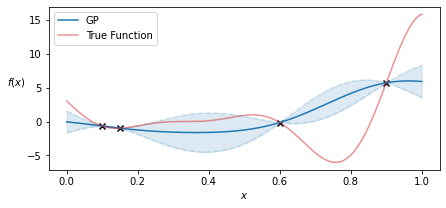

In [9]:
import torch
from aegis.test_problems import Forrester
from aegis import gp, transforms
import plotting
import numpy as np
import matplotlib.pyplot as plt

f = Forrester()

example_x = torch.as_tensor([
    [0.1],
    [0.15],
    [0.6],
    [0.9],
    ], dtype=torch.float64)

example_y = torch.as_tensor(f(example_x))

# bounds
ls_bounds = [1e-4, np.sqrt(example_x.shape[1])]
out_bounds = [1e-4, 10]

# Scale outputs
T = transforms.Transform_Standardize(example_y)
example_y = T.scale_mean(example_y)

model, likelihood = gp.create_and_fit_GP(
        train_x=example_x,
        train_y=example_y,
        ls_bounds=ls_bounds,
        out_bounds=out_bounds,
        n_restarts=10,
        verbose=False
    )


fig, ax = plt.subplots(figsize=(7,3))

plotting.gp_plot(ax, model, T, color=np.array([31, 119, 180])/255, label="GP")
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$     ", rotation=0)

test_x = np.linspace(0,1,1000)
test_y = f(test_x)
ax.plot(test_x, test_y, color='tab:red', alpha=0.5, label="True Function")

ax.legend()

plt.show()


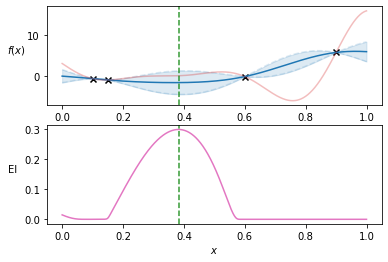

In [14]:
import matplotlib.pyplot as plt
import plotting
import numpy as np
from aegis.batch import ratios
import botorch

# Get EI
acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10,
}

EI = ratios.EI(
    model,
    torch.as_tensor(f.lb),
    torch.as_tensor(f.ub),
    [],
    **acq_params
)

fig, axs = plt.subplots(2)

plotting.gp_plot(axs[0], model, T, color=np.array([31, 119, 180])/255, label="GP")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f(x)$     ", rotation=0)

axs[0].plot(test_x, test_y, color='tab:red', alpha=0.3, label="True Function")

plotting.acq_plot(axs[1], EI)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("EI     ", rotation=0)

plotting.mark_acq_choice_plot(axs, EI, color="green")
